In [1]:
import pandas as pd
from FastFitClassifier import FastFitClassifier

In [2]:
classifier_type = 'relevance'

model_path = "./models/relevance/avsolatorio/GIST-small-Embedding-v0"
# model_path = './models/relevance/avsolatorio/GIST-Embedding-v0'

In [3]:
def import_labelled_data(path="data/labelled/data.json", group_relevant=True):
    data = pd.read_json(path, encoding="latin-1")
    data["relevance"] = data["class"].apply(
        lambda x: "relevant" if x != "irrelevant" else x
    )
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../data/labelled/data.json", group_relevant=False)

# drop null classes
test_dataset = test_dataset.dropna(subset=["class"])

print("Data loaded.")


# test_dataset = test_dataset.sample(250)
test_dataset = test_dataset.groupby(classifier_type).apply(lambda x: x.sample(500),include_groups=True).droplevel(0)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()

Loading data...
Data loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        998 non-null    object
 1   text       1000 non-null   object
 2   class      1000 non-null   object
 3   relevance  1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


/tmp/ipykernel_1359432/666879958.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_dataset = test_dataset.groupby(classifier_type).apply(lambda x: x.sample(500),include_groups=True).droplevel(0)


In [4]:
test_dataset

,url,text,class,relevance
0,https://dl.dell.com/manuals/all-products/esupr...,Inspiron 15 3000 Series Views Specifications C...,irrelevant,irrelevant
1,https://www.conservationevidence.com/individua...,Use taste-aversion to reduce predation of live...,Terrestrial Mammal Conservation,relevant
2,https://www.conservationevidence.com/individua...,(Summarised by: Chris Barrett)(Summarised by: ...,Marine Fish Conservation,relevant
3,https://www.conservationevidence.com/individua...,"A replicated, controlled study from March-July...",Farmland Conservation,relevant
4,https://www.deesignerds.com/_files/ugd/680821_...,Confidential Customized for Lorem Ipsum LLC Ve...,irrelevant,irrelevant
...,...,...,...,...
995,https://www.conservationevidence.com/individua...,A replicated study in 2005-2006 on arable farm...,Farmland Conservation,relevant
996,https://www.conservationevidence.com/individua...,"A study in 1995 of 76 toad patrol projects, 44...",Amphibian Conservation,relevant
997,https://defconwarningsystem.com/digest/wp-cont...,National stockpiles for radiological and nucle...,irrelevant,irrelevant
998,https://deafbeef.com/images/fluid_simulation.pdf,Fluid Simulation in Bases of Laplacian Eigenfu...,irrelevant,irrelevant


In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
classifier = FastFitClassifier(
    model_path=model_path,
    text_overlap_proportion=0.2,
    device='cuda:0'
)

Loading model from ./models/relevance/avsolatorio/GIST-small-Embedding-v0 ...
Model loaded.
Tokenizer loaded....


The model 'FastFit' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenceClassif


Classifier pipeline built.


In [ ]:
import torch
torch.cuda.empty_cache()

Data chunked....


Files	:   0%|          | 0/1000 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/98014 [00:00<?, ?it/s]

Calculated predictions.
Evaluating model...

-----------------------------------------------------

Classification Report: 
              precision    recall  f1-score   support

  irrelevant       1.00      0.99      0.99       500
    relevant       0.99      1.00      1.00       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000

-----------------------------------------------------
Accuracy: 0.995
Precision: 0.99502
Specificity: 0.992


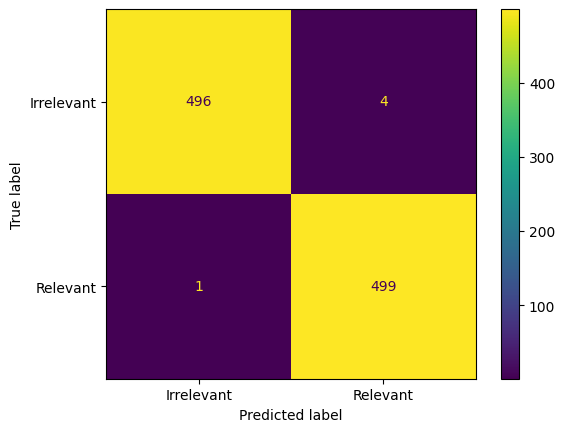

In [7]:

#! on fastfit/modeling.py, line 838, inserting **kwargs
#! it's easier than getting the tokenizer to stop outputting
#! extra info like token_type_ids

classifier.evaluate(
    test_dataset,
    metrics=[
        "accuracy",
        "precision",
        "classification-report",
        "specificity",
        "confusion-matrix-mpl",
    ],
    aggregate="majority",
)

In [8]:
t = test_dataset.sample(10)
classifier.predict(t)

Data chunked....


Files	:   0%|          | 0/5 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/232 [00:00<?, ?it/s]

Calculated predictions.


,url,text,class,relevance,predictions
147,https://www.mwe.go.ug/sites/default/files/libr...,1 2 3 4 5 6 7 8 9 10 11 12 13 NOTES: R 0 1. AL...,irrelevant,irrelevant,irrelevant
940,https://www.conservationevidence.com/individua...,This study is summarised as evidence for the f...,Marine Fish Conservation,relevant,relevant
404,https://www.conservationevidence.com/individua...,"A replicated, before-and-after study in 1988–2...",Bat Conservation,relevant,relevant
344,https://www.conservationevidence.com/individua...,Pay farmers to compensate for losses due to pr...,Terrestrial Mammal Conservation,relevant,relevant
746,https://www.conservationevidence.com/individua...,A replicated laboratory study conducted betwee...,Control of Freshwater Invasive Species,relevant,relevant


In [9]:
t = pd.DataFrame(
    [
        {"text": "Quantifying the effects of Entry Level Stewardship (ELS) on biodiversity at the farm scale: The Hillesden Experiment", "class": "relevant"},
        {"text": "The economy in the UK depends on a number of factors: the government", "class": "irrelevant"},
    ]
)
classifier.predict(t)

Data chunked....


Files	:   0%|          | 0/2 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/2 [00:00<?, ?it/s]

Calculated predictions.


,text,class,predictions
0,Quantifying the effects of Entry Level Steward...,relevant,relevant
1,The economy in the UK,irrelevant,irrelevant
